### Perform (binary) Image Segmentation with UNet

### 1. Data Preparation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
# from segmentation import build_unet, vgg16_unet, vgg19_unet, resnet50_unet, inception_resnetv2_unet, densenet121_unet
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score


In [2]:
base_directory = r'C:\data\forest_aerial_images_for_segmentation\Forest Segmented\Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [3]:
data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [4]:
im_dim = 256

In [5]:
def input_target_split(data,images_folder,masks_folder,dim):
    dataset = []
    for index, row in data.iterrows():
        image = load_img(os.path.join(images_folder, row['image']), target_size=(dim,dim)) 
        mask = load_img(os.path.join(masks_folder, row['mask']), target_size=(dim,dim), color_mode='grayscale')
        image = img_to_array(image)
        image = image/255.0
        mask = img_to_array(mask)
        mask = mask/255.0
        dataset.append((image,mask))
        print(f"\rProgress: {index}",end='')
    random.shuffle(dataset)
    X, Y = zip(*dataset)

    return np.array(X),np.array(Y)

In [6]:
X, Y = input_target_split(data, images_folder, masks_folder, im_dim)

Progress: 5107

In [7]:
print("Image Dimensions: ",X.shape)
print("Mask Dimensions: ",Y.shape)

Image Dimensions:  (5108, 256, 256, 3)
Mask Dimensions:  (5108, 256, 256, 1)


### 2. Check Data

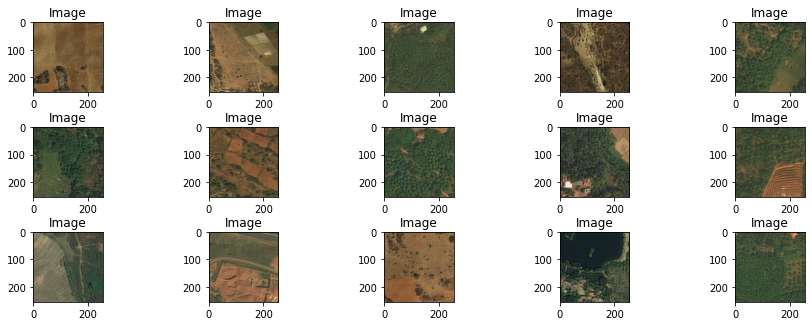

In [8]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(X[i])
    plt.title('Image')

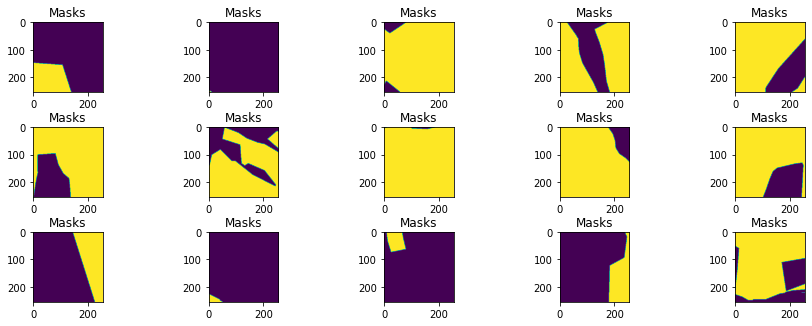

In [9]:
plt.figure(figsize = (15 , 9))
n = 0
for i in range(15):
    n+=1
    plt.subplot(5 , 5, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    plt.imshow(Y[i])
    plt.title('Masks')

In [10]:
split = round(X.shape[0]*0.80)
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

In [11]:
datagen = ImageDataGenerator()
testgen = ImageDataGenerator()

In [12]:
datagen.fit(X_train)
testgen.fit(X_test)

### 3. Model definition

In [13]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [14]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [15]:
input_shape = (im_dim, im_dim, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

#### Compiling the model

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])

c:\Users\steph\anaconda3\envs\ds_playground\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
model_path = "tree.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

In [18]:
hist = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=8),
                                        validation_data=testgen.flow(X_test,Y_test,batch_size=8),
                                        epochs=50, callbacks=[earlystop, checkpoint])

Epoch 1/50


C:\Users\steph\AppData\Local\Temp\ipykernel_11920\2842337293.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=8),


: 

: 